In [1]:
from ema_workbench import (Model, RealParameter,CategoricalParameter, IntegerParameter, TimeSeriesOutcome, ema_logging, perform_experiments)
# from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework.evaluators import MultiprocessingEvaluator
from ema_workbench.em_framework.outcomes import ArrayOutcome, ScalarOutcome
from ema_workbench.util import ema_exceptions
#from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis import pairs_plotting
#feature scoring
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import prim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from pandas.core.indexing import convert_missing_indexer, convert_to_index_sliceable
import os 
import warnings
from math import floor
from ema_workbench.analysis import dimensional_stacking
from scipy import stats

# Change the current working directory
os.chdir('C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\src')
#print("Current working directory: {0}".format(os.getcwd()))

In [2]:
indir = "C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs_rdm\\outputs_v5\\n_1000\\"
outdir ='C:\\Users\\wb558960\\OneDrive - WBG\\CCDRs LAC\\Argentina\\DeepDives\\Vaca Muerta\\Python\\outputs_rdm\\plots\\'

In [3]:
colnames= ['year','run','Conv_gas_price','Unconv_gas_price','Conv_oil_price','Unconv_oil_price',
'Conv_gas_ds_capex','Unconv_gas_ds_capex','Conv_oil_ds_capex','Unconv_oil_ds_capex',
'Conv_gas_opex','Unconv_gas_opex','Conv_oil_opex','Unconv_oil_opex',
'Conv_gas_domestic revenue','Unconv_gas_domestic revenue','Conv_oil_domestic revenue','Unconv_oil_domestic revenue',
'Conv_gas_export revenue','Unconv_gas_export revenue','Conv_oil_export revenue','Unconv_oil_export revenue',
'Conv_gas_production subsidy','Unconv_gas_production subsidy','Conv_oil_production subsidy','Unconv_oil_production subsidy',
'Conv_gas_import subsidy','Unconv_gas_import subsidy','Conv_oil_import subsidy','Unconv_oil_import subsidy',
'Conv_gas_royalties','Unconv_gas_royalties','Conv_oil_royalties','Unconv_oil_royalties',
'Conv_gas_export duties','Unconv_gas_export duties','Conv_oil_export duties','Unconv_oil_export duties',
'Conv_gas_trade balance','Unconv_gas_trade balance','Conv_oil_trade balance','Unconv_oil_trade balance',
'Conv_gas_us_capex','Unconv_gas_us_capex','Conv_oil_us_capex','Unconv_oil_us_capex',
'Conv_gas_starts','Unconv_gas_starts','Conv_oil_starts','Unconv_oil_starts',
'Conv_gas_discount_factor','Unconv_gas_discount_factor','Conv_oil_discount_factor','Unconv_oil_discount_factor']


In [4]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [5]:
fbal = tradebal.groupby('run').sum()
fbal=fbal/383100000000*100

# pbal =  physbal.groupby('run').mean()
# print(pbal.head())

In [6]:
data = pd.merge(outcomes, experiments)
data = data.rename(columns= {'Unnamed: 0':'run'}).set_index('run')
data = pd.merge(data,fbal, left_on = 'run',right_on= 'run')

In [7]:
data.columns

Index(['npv_gdp', 'npv_unsub_gdp', 'total_ft_gdp', 'wells_total',
       'gdp_npv_conv_gas', 'gdp_npv_conv_oil', 'gdp_npv_unconv_gas',
       'gdp_npv_unconv_oil', 'gdp_ft_conv_gas', 'gdp_ft_conv_oil',
       ...
       'Conv_oil_us_capex', 'Unconv_oil_us_capex', 'Conv_gas_starts',
       'Unconv_gas_starts', 'Conv_oil_starts', 'Unconv_oil_starts',
       'Conv_gas_discount_factor', 'Unconv_gas_discount_factor',
       'Conv_oil_discount_factor', 'Unconv_oil_discount_factor'],
      dtype='object', length=121)

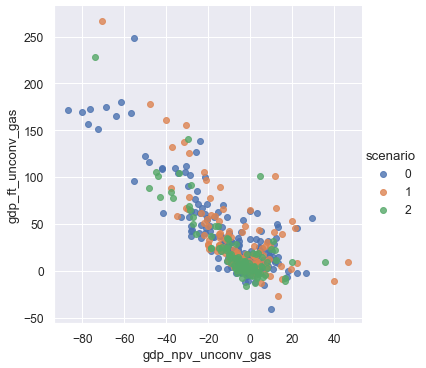

In [82]:
#define scenario
#&(data['t_rate_gas'] > .003)&

data.scenario = 0 
data.loc[(data['rcp'] =='CURR')&(data['wells_total'] >=16000), 'scenario'] =0
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] >=16000), 'scenario'] =1
data.loc[(data['rcp'] =='1.5')&(data['wells_total'] <16000), 'scenario'] = 2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

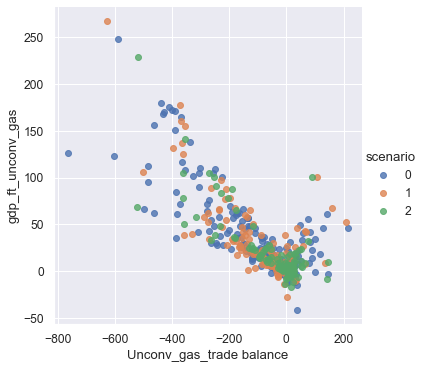

In [83]:

plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

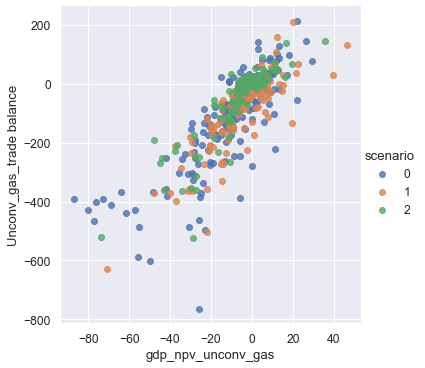

In [84]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='scenario', legend=True)
plt.show()

In [85]:
#define success

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'success3'] ="Positive Impacts"
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'success3'] ="Negative Impacts"

data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0), 'success_ft'] =1
data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0), 'success_ft'] =0

data.loc[(data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0), 'success_tb'] =1
data.loc[(data['Unconv_gas_trade balance'] <0)|(data['gdp_npv_unconv_gas'] <0), 'success_tb'] =0

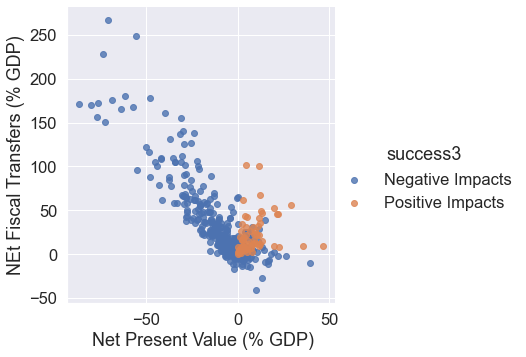

In [86]:
#add legend and axis labels here
sns.set(font_scale = 1.5)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='success3', legend=True)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="NEt Fiscal Transfers (% GDP)")

plt.show()

In [87]:
pd.crosstab(data['scenario'],data['success_ft'])


success_ft,0.0,1.0
scenario,,
0,189,61
1,101,40
2,88,21


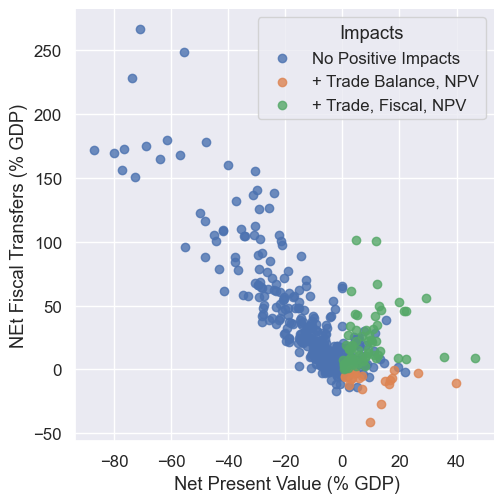

In [18]:
#graph for executive Summary

data.loc[(data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0), 'three_level'] = 0
data.loc[(data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0), 'three_level'] =1
data.loc[(data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="NEt Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Trade Balance, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

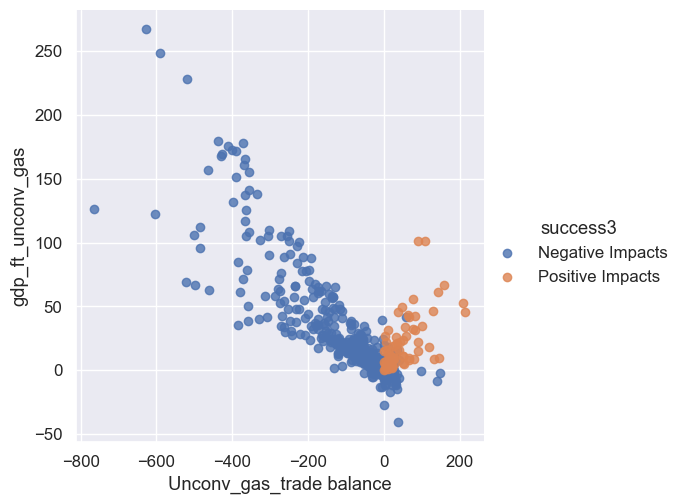

In [19]:
#do trade and fiscal impact on the axis - then color by npv

# data["gdp_npv_unconv_gas"]
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='success3', legend=True)
plt.show()

# 

In [91]:
print(pd.Series.corr(data['scenario'],data['wells_total']))

-0.13840168357417076


In [92]:
# pd.crosstab(data['scenario'],data['success3'])

from scipy import stats
crosstab = pd.crosstab(data['success3'],data['scenario'])
stats.chi2_contingency(crosstab)

(1.0187666559235817,
 0.6008660018478129,
 2,
 array([[214.5  , 120.978,  93.522],
        [ 35.5  ,  20.022,  15.478]]))

In [93]:
# pd.crosstab(data['scenario'],data['success_ft'])

crosstab = pd.crosstab(data['scenario'],data['success_ft'])
stats.chi2_contingency(crosstab)

(2.761456382434954,
 0.25139542245205515,
 2,
 array([[189.   ,  61.   ],
        [106.596,  34.404],
        [ 82.404,  26.596]]))

In [96]:
pd.crosstab(data['scenario'],data['success_ft'])


success_ft,0.0,1.0
scenario,,
0,189,61
1,101,40
2,88,21


In [97]:
pd.crosstab(data['scenario'],data['success_tb'])

success_tb,0.0,1.0
scenario,,
0,206,44
1,121,20
2,80,29


In [98]:
crosstab = pd.crosstab(data['scenario'],data['success_tb'])
stats.chi2_contingency(crosstab)

(6.594777964250235,
 0.03697959584401809,
 2,
 array([[203.5  ,  46.5  ],
        [114.774,  26.226],
        [ 88.726,  20.274]]))

In [99]:
crosstab = pd.crosstab(data['scenario'],data.loc[data['wells_total']<=10000,'wells_total'])
stats.chi2_contingency(crosstab)

(10.999999999999998,
 0.35751800242792586,
 10,
 array([[0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
         0.63636364, 0.63636364, 0.63636364, 0.63636364, 0.63636364,
         0.63636364],
        [0.36363636, 0.36363636, 0.36363636, 0.36363636, 0.36363636,
         0.36363636, 0.36363636, 0.36363636, 0.36363636, 0.36363636,
         0.36363636]]))

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


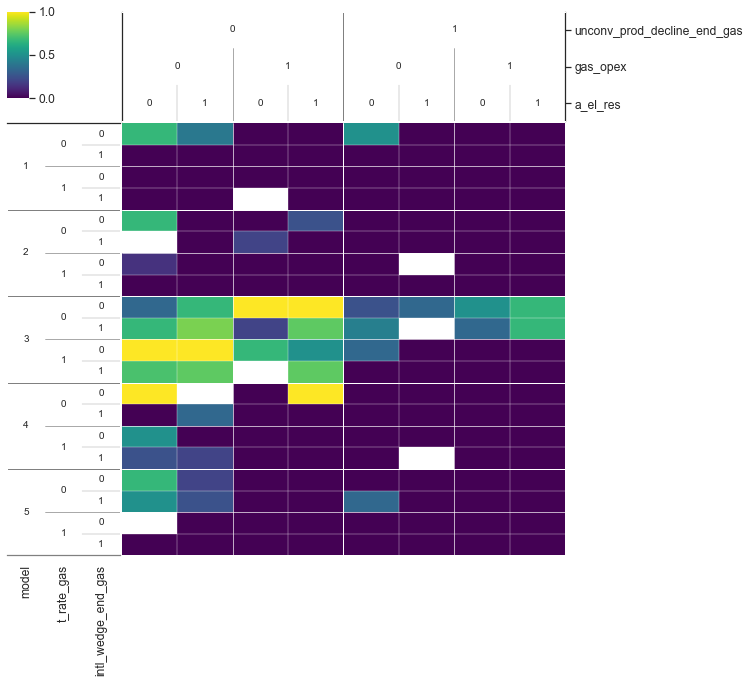

In [27]:
%matplotlib inline

x = experiments
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, categories = True, labels = True)
plt.show()

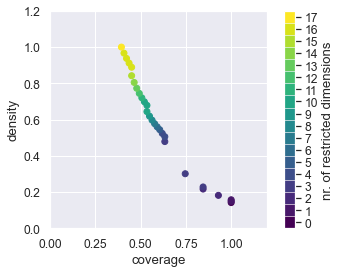

In [28]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)
# y = (data['gdp_npv_unconv_gas'] <0)|(data['gdp_ft_unconv_gas'] <0)|(data['Unconv_gas_trade balance'] <0)
prim_alg = prim.Prim(x, y, threshold=0.05)
box1 = prim_alg.find_box() 

%matplotlib inline
box1.show_tradeoff()
plt.show()

coverage    0.605634
density     0.544304
id                10
mass           0.158
mean        0.544304
res_dim            5
Name: 10, dtype: object

                   box 10                                          
                      min       max                       qp values
a_gas_ind        0.000012  0.056945     [-1.0, 0.40123487996414153]
a_gas_res        0.000068  0.054729     [-1.0, 0.40123487996414153]
model             {POLES}   {POLES}  [1.4849962235781214e-13, -1.0]
share_covered    0.018515  0.699892      [0.3218755053078168, -1.0]
profit_tax_rate  0.049233    0.4999      [0.3622333348390892, -1.0]



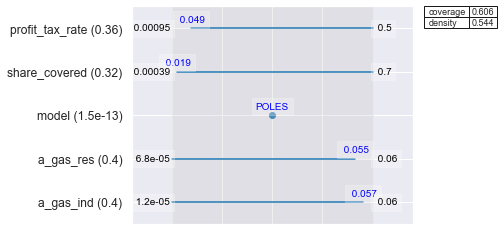

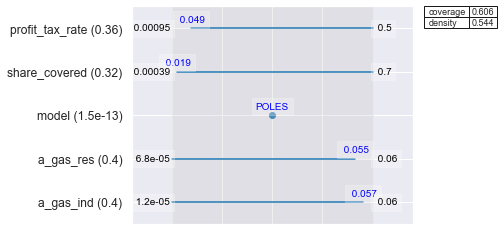

In [30]:
# %matplotlib notebook
box1.inspect(i=10, style='table')
box1.inspect(i=10, style='graph')

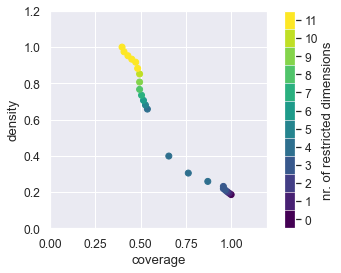

In [40]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['Unconv_gas_trade balance'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage    0.494624
density     0.851852
id                15
mass           0.108
mean        0.851852
res_dim           10
Name: 15, dtype: object

                                     box 15                   \
                                        min              max   
unconv_prod_decline_end_gas        0.000214         0.101736   
a_gas_res                          0.000068         0.054729   
oil_ex_cap_end                 33240.525868     74464.274672   
model                               {POLES}          {POLES}   
discount                             0.0332         0.089936   
share_covered                      0.015944         0.699892   
us_capex_gas                 3413208.357844  10992346.382756   
foreign_capex_share                0.081679         0.999293   
gas_demand_decline_speed                5.5             30.0   
cons_wedge_end_oil                 0.724921         4.998236   

                                                             
                  

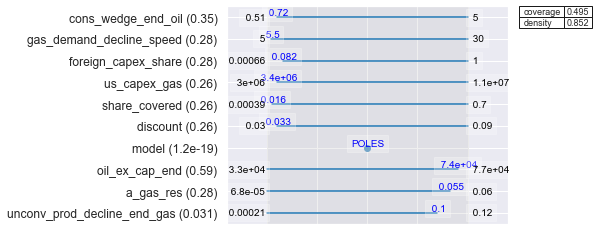

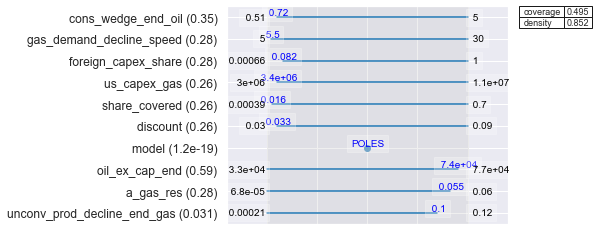

In [41]:
%matplotlib inline
box1.inspect(i=15, style='table')
box1.inspect(i=15, style='graph')

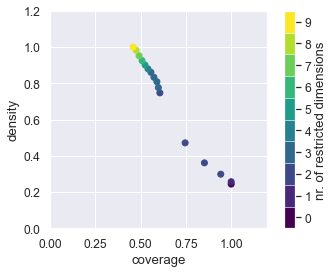

In [37]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage    0.459016
density          1.0
id                15
mass           0.112
mean             1.0
res_dim            9
Name: 15, dtype: object

                          box 15                \
                             min           max   
m                    2033.577271  24072.791763   
discount                0.030087      0.087202   
model                    {POLES}       {POLES}   
foreign_capex_share     0.066115      0.999293   
t_rate_gas             -0.042694      0.040138   
price_threshold_oil    50.923581     69.980888   
profit_tax_rate         0.054112        0.4999   
gas_ex_cap_increase          2.5          30.0   
price_floor_gas         2.007128      3.995736   

                                                                  
                                                       qp values  
m                                    [-1.0, 0.14979510372633736]  
discount                               [-1.0, 0.383932597893179]  
model                         

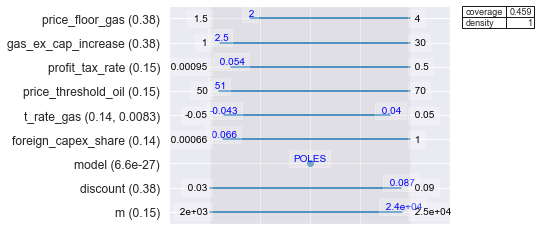

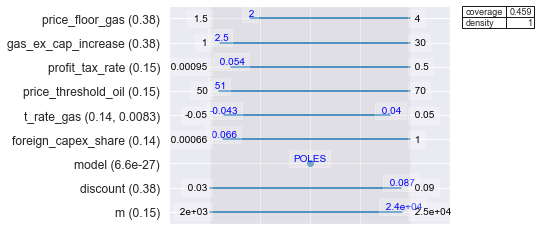

In [39]:
%matplotlib inline
box1.inspect(i=15, style='table')
box1.inspect(i=15, style='graph')

In [42]:
#highly supported - high subsidy rate high subsidy shar
data.loc[(data['prod_subsidy_p_ratio'] >data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] >data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] >data["share_covered"].quantile(.5)), 'support'] =0
data.loc[(data['prod_subsidy_p_ratio'] <=data["prod_subsidy_p_ratio"].quantile(.5))&(data['public_ds_capex_share'] <=data["public_ds_capex_share"].quantile(.5))&(data['share_covered'] <= data["share_covered"].quantile(.5)), 'support'] =1

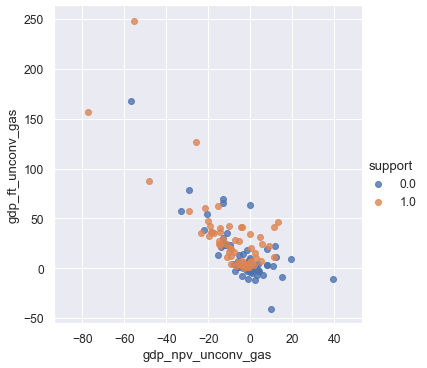

In [43]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

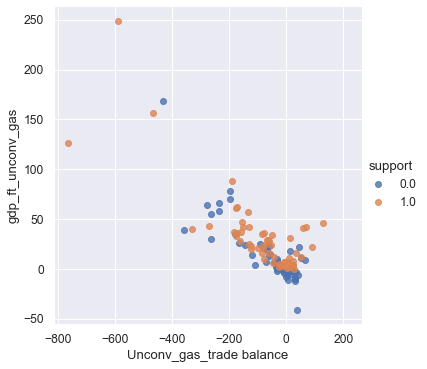

In [44]:
plot = sns.lmplot(x="Unconv_gas_trade balance", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

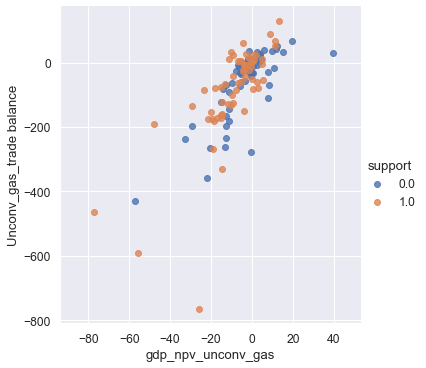

In [45]:
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=data, fit_reg=False, hue='support', legend=True)
plt.show()

In [46]:
# diverging_colors = sns.color_palette("RdBu", 3)

# plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=data, fit_reg=False, hue="Unconv_gas_trade balance", legend=True)
# plt.show()

In [47]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# z =data['gdp_npv_unconv_gas']
# y =data['gdp_ft_unconv_gas']
# x =data['Unconv_gas_trade balance']

# c = (data['success3']>0)
# ax.scatter(x, y, z, c=c, marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


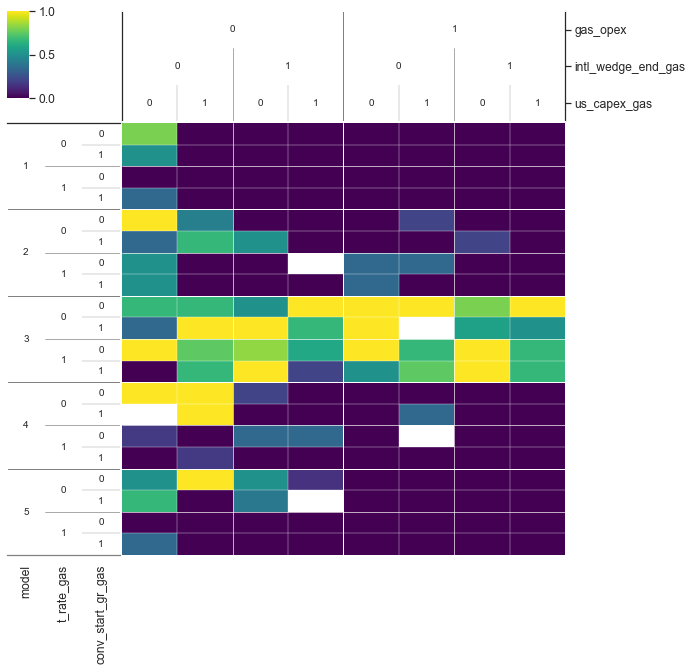

In [48]:
%matplotlib inline
x = experiments
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

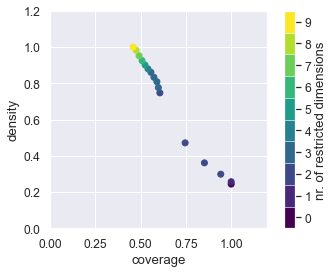

In [49]:
y = (data['gdp_npv_unconv_gas'] >0)&(data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

coverage    0.459016
density          1.0
id                15
mass           0.112
mean             1.0
res_dim            9
Name: 15, dtype: object

                          box 15                \
                             min           max   
m                    2033.577271  24072.791763   
discount                0.030087      0.087202   
model                    {POLES}       {POLES}   
foreign_capex_share     0.066115      0.999293   
t_rate_gas             -0.042694      0.040138   
price_threshold_oil    50.923581     69.980888   
profit_tax_rate         0.054112        0.4999   
gas_ex_cap_increase          2.5          30.0   
price_floor_gas         2.007128      3.995736   

                                                                  
                                                       qp values  
m                                    [-1.0, 0.14979510372633736]  
discount                               [-1.0, 0.383932597893179]  
model                         

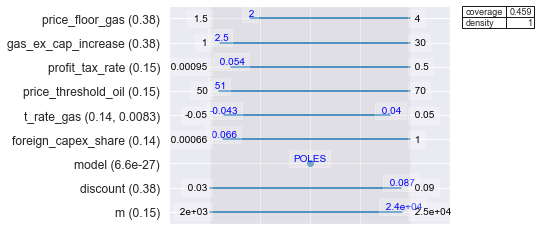

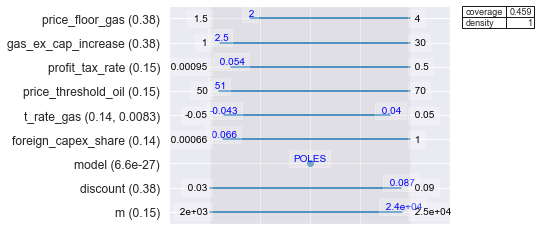

In [51]:
%matplotlib inline
box1.inspect(i=15, style='table')
box1.inspect(i=15, style='graph')

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


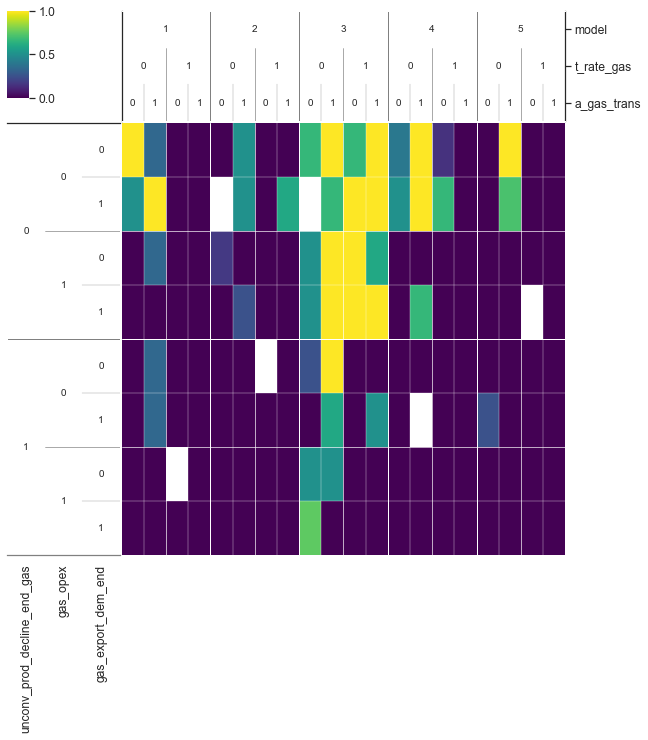

In [52]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] >0)&(data['gdp_npv_unconv_gas'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

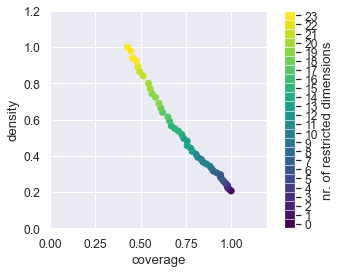

In [54]:
y = (data['Unconv_gas_trade balance'] >0)&(data['gdp_ft_unconv_gas'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box2 = prim_alg.find_box() 

box2.show_tradeoff()
plt.show()

coverage    0.757282
density      0.45614
id                20
mass           0.342
mean         0.45614
res_dim           13
Name: 20, dtype: object

                                  box 20                \
                                     min           max   
unconv_prod_decline_end_gas     0.000214      0.099282   
oil_demand_decline_speed        5.000000     29.500000   
t_rate_gas                     -0.049815      0.044290   
a_oil_trans                     0.000073      0.057049   
conv_prod_decline_end_oil       0.000162      0.114227   
Unnamed: 0                      0.000000    479.000000   
prod_subsidy_p_ratio            1.001063      1.950941   
gas_ex_cap_end               3798.529063  42735.993403   
cons_wedge_end_oil              0.716124      4.183785   
gas_export_dem_end              0.048016      0.998616   
a_el_ind                        0.003609      0.059934   
profit_tax_rate                 0.029524      0.499900   
gas_ex_cap_increase             2.500

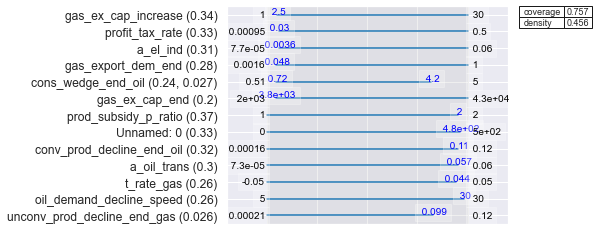

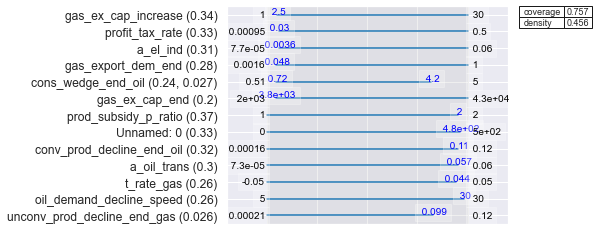

In [55]:
%matplotlib inline
box2.inspect(i=20, style='table')
box2.inspect(i=20, style='graph')

C:\Users\wb558960\Anaconda3\envs\arg_ccdr\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:404: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


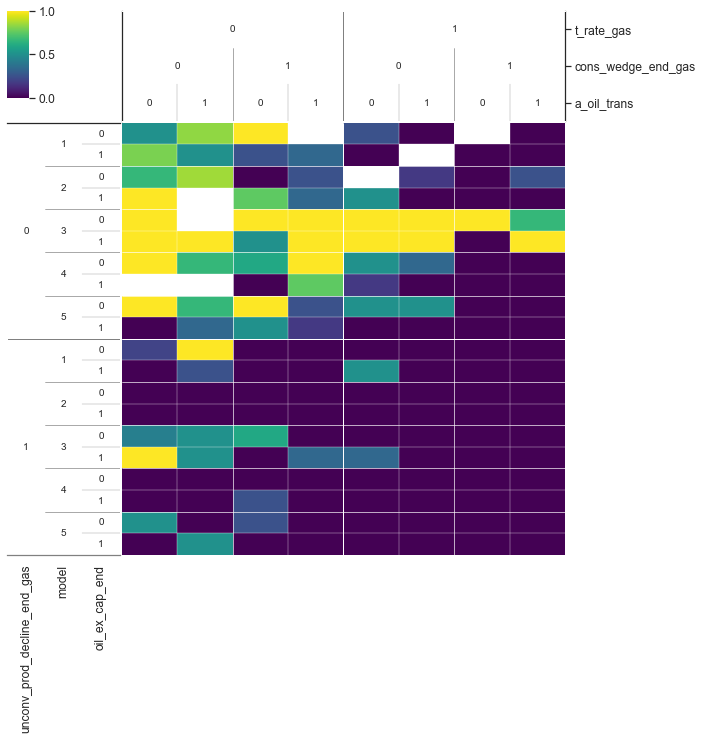

In [56]:
%matplotlib inline
x = experiments
y = (data['Unconv_gas_trade balance'] >0)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

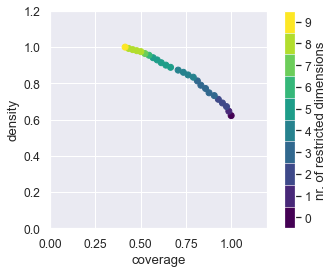

In [58]:
y = (data['Unconv_oil_trade balance'] >0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.414791
density          1.0
id                25
mass           0.258
mean             1.0
res_dim            9
Name: 25, dtype: object

                                box 25             \
                                   min        max   
t_rate_oil                   -0.049826   0.013552   
unconv_prod_decline_end_oil   0.000116   0.068192   
intl_wedge_end_oil            0.506001   4.753017   
price_threshold_oil          50.008259  69.074512   
share_covered                 0.000395   0.671439   
gas_demand_decline_speed      6.500000  30.000000   
oil_export_dem_end            0.044170   0.999790   
a_el_ind                      0.002752   0.059934   
a_oil_trans                   0.002879   0.059949   

                                                             
                                                  qp values  
t_rate_oil                   [-1.0, 3.6951052481108244e-11]  
unconv_prod_decline_end_oil   [-1.0, 9.337727231252123e-08]  
intl_wedge_end_oi

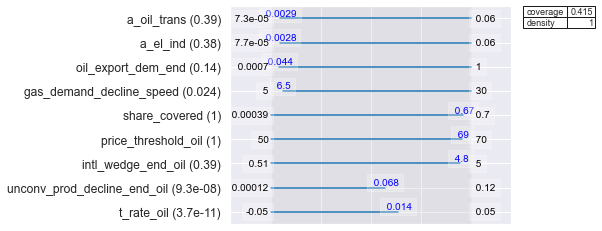

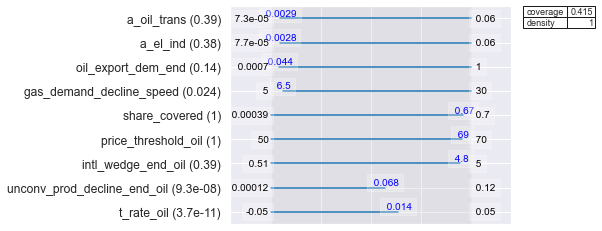

In [60]:
%matplotlib inline
box6.inspect(i=25, style='table')
box6.inspect(i=25, style='graph')

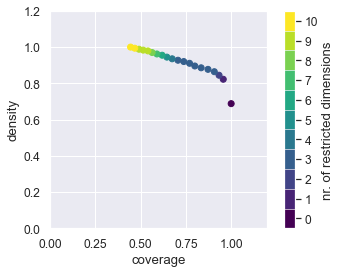

In [63]:
y = (data['gdp_npv_unconv_gas'] <0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box4 = prim_alg.find_box() 

box4.show_tradeoff()
plt.show()

coverage    0.674419
density     0.935484
id                10
mass           0.496
mean        0.935484
res_dim            4
Name: 10, dtype: object

                                                box 10  \
                                                   min   
model                      {GCAM, REMIND, MESSAGE, WB}   
gas_opex                                      7.906256   
intl_wedge_end_gas                            0.897043   
conv_prod_decline_end_gas                     0.006238   

                                                        \
                                                   max   
model                      {GCAM, REMIND, MESSAGE, WB}   
gas_opex                                     19.986032   
intl_wedge_end_gas                            4.998737   
conv_prod_decline_end_gas                     0.119882   

                                                          
                                               qp values  
model                      [8.730

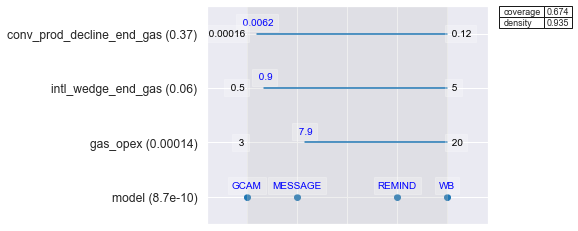

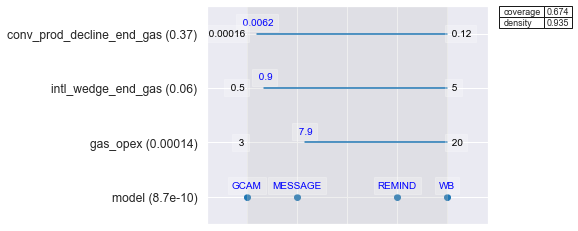

In [65]:
%matplotlib inline
box4.inspect(i=10, style='table')
box4.inspect(i=10, style='graph')

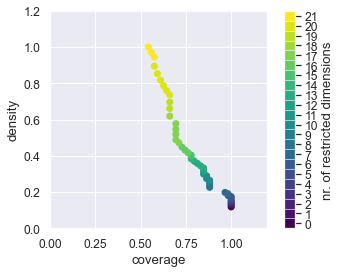

In [68]:
y = (data['gdp_ft_unconv_gas'] <0)
prim_alg = prim.Prim(x, y, threshold=0.15)
box5 = prim_alg.find_box() 

box5.show_tradeoff()
plt.show()

coverage    0.966102
density     0.197917
id                10
mass           0.576
mean        0.197917
res_dim            7
Name: 10, dtype: object

                            box 10                \
                               min           max   
price_floor_gas       1.504314e+00  3.879415e+00   
share_covered         8.291889e-02  6.998919e-01   
prod_subsidy_p_ratio  1.108402e+00  1.998586e+00   
a_oil_ind             3.012681e-03  5.989047e-02   
well_life             1.150000e+01  3.500000e+01   
us_capex_oil          3.367770e+06  1.099857e+07   
price_floor_oil       3.573837e+01  4.931769e+01   

                                                                 
                                                      qp values  
price_floor_gas                      [-1.0, 0.3380676109980124]  
share_covered                        [0.1958088073634816, -1.0]  
prod_subsidy_p_ratio                [0.24443771481836543, -1.0]  
a_oil_ind                            [0.3380676109

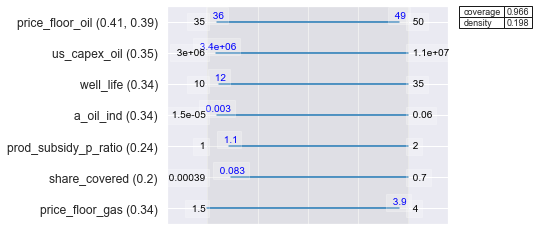

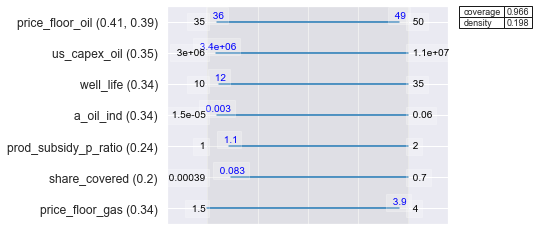

In [70]:
%matplotlib inline
box5.inspect(i=10, style='table')
box5.inspect(i=10, style='graph')

In [71]:
from scipy import stats
crosstab = pd.crosstab(data['success3'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support           0.0  1.0
success3                  
Negative Impacts   54   54
Positive Impacts    4    8


(0.626622172784575,
 0.42859703689425854,
 1,
 array([[52.2, 55.8],
        [ 5.8,  6.2]]))

In [72]:
crosstab = pd.crosstab(data['success_tb'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support     0.0  1.0
success_tb          
0.0          43   54
1.0          15    8


(2.4655513945720844,
 0.11636685998984517,
 1,
 array([[46.88333333, 50.11666667],
        [11.11666667, 11.88333333]]))

In [73]:
crosstab = pd.crosstab(data['success_ft'],data['support'])
print(crosstab)
stats.chi2_contingency(crosstab)

support     0.0  1.0
success_ft          
0.0          48   49
1.0          10   13


(0.08190783224948894,
 0.774728432925373,
 1,
 array([[46.88333333, 50.11666667],
        [11.11666667, 11.88333333]]))

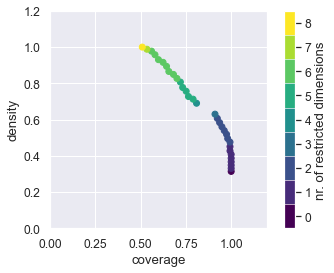

In [74]:
x = experiments
y = (data['Unconv_gas_trade balance'] <-100)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.910828
density     0.629956
id                15
mass           0.454
mean        0.629956
res_dim            3
Name: 15, dtype: object

                               box 15                                         
                                  min       max                      qp values
t_rate_gas                  -0.009414  0.049948  [4.384661299895155e-14, -1.0]
cons_wedge_end_gas           1.341725  4.993738   [0.001294127050712441, -1.0]
unconv_prod_decline_end_gas  0.005270  0.119929     [0.2589515181074382, -1.0]



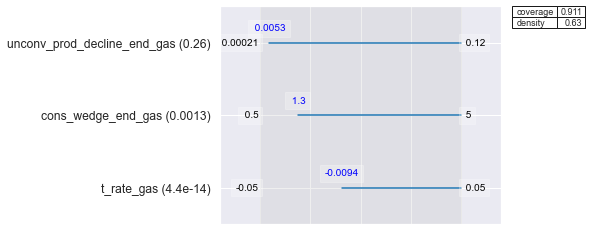

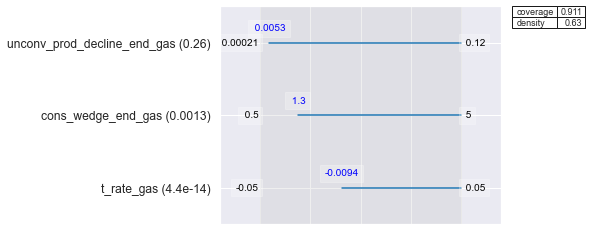

In [75]:
%matplotlib inline
box6.inspect(i=15, style='table')
box6.inspect(i=15, style='graph')

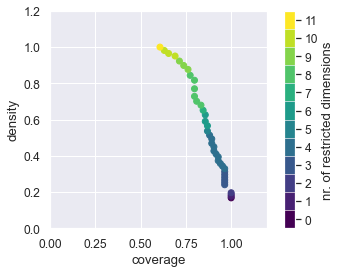

In [78]:
x = experiments
y = (data['gdp_npv_unconv_gas'] <-20)
prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.797619
density     0.817073
id                30
mass           0.164
mean        0.817073
res_dim            8
Name: 30, dtype: object

                                                box 30  \
                                                   min   
conv_prod_decline_end_gas                     0.000156   
price_floor_oil                              35.027472   
t_rate_gas                                    0.006941   
cons_wedge_end_gas                            2.063628   
model                      {GCAM, REMIND, MESSAGE, WB}   
intl_wedge_end_gas                            1.190899   
a_el_res                                      0.003511   
oil_export_dem_end                            0.033021   

                                                        \
                                                   max   
conv_prod_decline_end_gas                     0.115177   
price_floor_oil                              49.041416   
t_rate_gas                          

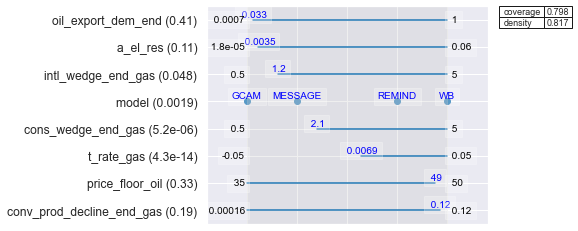

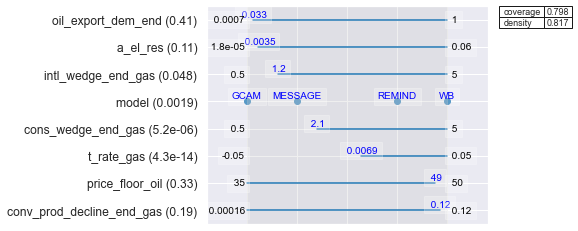

In [79]:
%matplotlib inline
box6.inspect(i=30, style='table')
box6.inspect(i=30, style='graph')

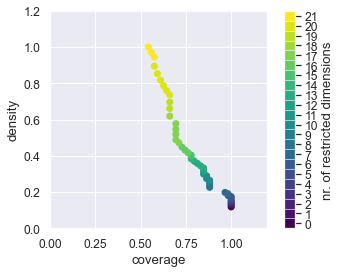

In [80]:
x = experiments
y = (data['gdp_ft_unconv_gas'] <0)


prim_alg = prim.Prim(x, y, threshold=0.15)
box6 = prim_alg.find_box() 

box6.show_tradeoff()
plt.show()

coverage    0.694915
density     0.518987
id                30
mass           0.158
mean        0.518987
res_dim           17
Name: 30, dtype: object

                                              box 30  \
                                                 min   
a_el_ind                                    0.000077   
t_rate_e                                   -0.049976   
a_gas_ind                                   0.000012   
oil_ex_cap_increase                              1.0   
oil_opex                                    3.017399   
price_threshold_oil                        50.008259   
share_covered                               0.133386   
model                 {GCAM, POLES, REMIND, MESSAGE}   
prod_subsidy_p_ratio                        1.355451   
us_capex_oil                          3872320.233753   
us_capex_gas                          3769494.414262   
well_life                                       11.5   
price_floor_oil                            35.738367   
a_oil_ind

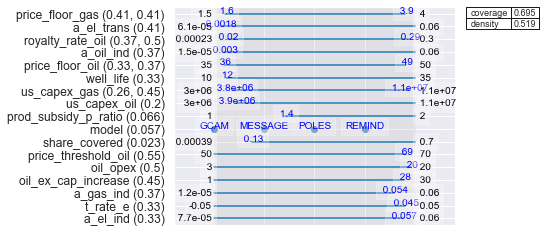

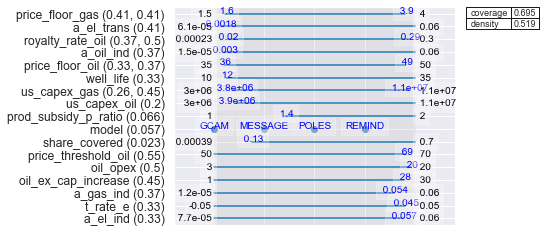

In [81]:
%matplotlib inline
box6.inspect(i=30, style='table')
box6.inspect(i=30, style='graph')

# subset

In [ ]:
param_names =['rcp', 'T_bond_rate','arg_sov_risk','opp_cost_own_finance','share_own_capital','opp_cost_debt',
              'pes_oil','pes_gas','t_rate_gas','t_rate_oil','t_rate_e','us_capex_gas','us_capex_oil',
              'm','oil_opex','gas_opex','share_covered','prod_subsidy_p_ratio','royalty_rate_gas',
              'duty_rate_gas','royalty_rate_oil','duty_rate_oil','price_threshold_gas','price_threshold_oil',
              'price_floor_gas','price_floor_oil','conv_start_gr_gas','conv_start_gr_oil',
              'conv_prod_decline_end_gas','conv_prod_decline_end_oil','unconv_prod_decline_end_gas',
              'unconv_prod_decline_end_oil','cons_wedge_end_gas','cons_wedge_end_oil','intl_wedge_end_gas',
              'intl_wedge_end_oil','a_gas_trans','a_gas_res','a_gas_ind','a_oil_trans','a_oil_res',
              'a_oil_ind','a_el_trans','a_el_res','a_el_ind','well_life','gas_ex_cap_end',
              'gas_ex_cap_increase','oil_ex_cap_end','oil_ex_cap_increase',
              'gas_export_dem_end','oil_export_dem_end',
              'gas_demand_decline_speed','oil_demand_decline_speed','public_ds_capex_share']


In [ ]:
d = data[((data['m']<30000)&
#     (data['unconv_prod_decline_end_gas']<.05)]
    (data['t_rate_gas']<.03))]

In [ ]:
data['subset'] =0
data.loc[(data['m']<30000)&  
         (data['t_rate_gas']<.03),'subset'] = 1
#          (data['unconv_prod_decline_end_gas']<.05),'subset'] = 1

In [ ]:
d.describe()

In [ ]:
x = d[param_names]

In [ ]:
# crosstab = pd.crosstab(d['three_level'],d['support'])
# stats.chi2_contingency(crosstab)

In [ ]:
# plot = sns.lmplot(x="gdp_ft_unconv_gas", y="gdp_npv_unconv_gas", data=d, fit_reg=False, hue='success3', legend=True)
# plt.show()

In [ ]:
# #data_cut.describe()
# pd.crosstab(d['subset'],d['three_level'])

In [ ]:
#graph for executive Summary

d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['Unconv_gas_trade balance'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

sns.set(font_scale = 1.1)
plot = sns.lmplot(x="gdp_npv_unconv_gas", y="gdp_ft_unconv_gas", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Fiscal Transfers (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Trade Balance, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
sns.set(font_scale = 1.1)
d.loc[(d['gdp_npv_unconv_gas'] <0)|(d['gdp_ft_unconv_gas'] <0)|(d['Unconv_gas_trade balance'] <0), 'three_level'] = 0
d.loc[(d['gdp_ft_unconv_gas'] >0)&(d['gdp_npv_unconv_gas'] >0), 'three_level'] =1
d.loc[(d['gdp_npv_unconv_gas'] >0)&(d['gdp_ft_unconv_gas'] >0)&(d['Unconv_gas_trade balance'] >0), 'three_level'] =2

plot = sns.lmplot(x="gdp_npv_unconv_gas", y="Unconv_gas_trade balance", data=d, fit_reg=False, hue='three_level', legend=True, legend_out = False)
plot.set_titles("Impacts of Vaca Muerta")  # use this argument literally
plot.set_axis_labels(x_var=" Net Present Value (% GDP)", y_var="Net Trade Balance (% GDP)")
# plt.legend(title='Impacts', loc='upper left', labels=['No Positive Impacts', '+ Trade Balance and NPV Impacts','+ Trade Balance, Fiscal, NPV Impacts'])
new_title = 'Impacts'
plot._legend.set_title(new_title)
# replace labels
new_labels = ['No Positive Impacts', '+ Fiscal Transfers, NPV','+ Trade, Fiscal, NPV']
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
# summary = data.loc[(data['subset'] ==1)&(data['Unconv_gas_trade balance'] <-50)]
# # summary.to_csv(outdir+"summary_neg_tb.csv")

In [ ]:
pd.crosstab(d['scenario'],d['success_tb'])
#1839 #588 #32%

In [ ]:
pd.crosstab(d['scenario'],d['success_ft'])
#1839 #303 #16%

In [ ]:
d.loc[(d['wells_total']>10000), 'wells_high'] = 1
d.loc[(d['wells_total']<=10000), 'wells_high'] = 0

data.loc[(data['wells_total']>10000), 'wells_high1'] = 1
data.loc[(data['wells_total']<=10000), 'wells_high1'] = 0


d['wells_high'].describe()
pd.crosstab(d['scenario'],d['wells_high'])

In [ ]:
pd.crosstab(d['scenario'],d['success3'])
#106 #5.7%

In [ ]:
pd.crosstab(d['success3'],d['wells_high'])

In [ ]:
crosstab = pd.crosstab(d['success3'],d['wells_high'])
print(crosstab)
stats.chi2_contingency(crosstab)

In [ ]:
crosstab = pd.crosstab(data['success3'],data['wells_high1'])
print(crosstab)
stats.chi2_contingency(crosstab)

In [ ]:
# pd.crosstab(data['scenario'],data['success3'])

crosstab = pd.crosstab(d['success3'],d['scenario'])
stats.chi2_contingency(crosstab)

In [ ]:
pd.crosstab(d['success3'],d['support'])

In [ ]:
crosstab = pd.crosstab(d['success3'],d['support'])
stats.chi2_contingency(crosstab)

In [ ]:
outcomes = pd.read_csv(indir+"vm_outcomes_2.csv")
experiments = pd.read_csv(indir+"vm_experiments_2.csv")
tradebal= pd.read_csv(indir+"fiscal ts outcomes_2.csv",index_col = False,names = colnames, skiprows = 1 )
physbal = pd.read_csv(indir+"physical ts outcomes_2.csv" )

In [ ]:
y =d['gdp_ft_unconv_gas'] >0
prim_alg = prim.Prim(x, y, threshold=0.1)
box1 = prim_alg.find_box() 

box1.show_tradeoff()
plt.show()

In [ ]:
%matplotlib inline
box1.inspect(i=30, style='table')
box1.inspect(i=30, style='graph')

In [ ]:
%matplotlib inline

y = (d['gdp_ft_unconv_gas'] >0)
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=2)
plt.show()